In [1]:
import google.generativeai as genai
from google.generativeai.types import GenerationConfig
import os
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
import sacrebleu
from fyp_work.paper_to_equation.Generation.Equation_BaseDataset import BaseDataset

c:\Users\kyanj\anaconda3\envs\fyp_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
api_key = os.getenv("GEMINI_API_KEY")  # Returns None if the variable is not set
# Check if the API key is loaded correctly
if api_key:
    print("API key loaded successfully!")
else:
    print("API key not found. Please ensure it is set as an environment variable.")

genai.configure(api_key=api_key)

API key loaded successfully!


In [3]:
class GeminiDataset(BaseDataset):
    def __init__(self, num, filepath):
        super().__init__(num, filepath)

    def get_columns(self):
        return ["text_input", "output"]

In [4]:
# Path to CSV file
csv_file_path = "Data/gemini_training_4.csv"

data = GeminiDataset(500, csv_file_path)
data.create()
print(len(data.dataset))

Generating dataset: 100%|██████████| 500/500 [00:07<00:00, 65.21it/s]

500


In [7]:
dataset = data.dataset
print(dataset[0])

{'text_input': '\n<mml:mrow>\n<mml:msqrt>\n<mml:mi>c</mml:mi>\n</mml:msqrt>\n<mml:mo>+</mml:mo>\n<mml:mrow>\n<mml:mi>sin</mml:mi>\n<mml:mfenced>\n<mml:msub>\n<mml:mi>Δ</mml:mi>\n<mml:mi>1</mml:mi>\n</mml:msub>\n</mml:mfenced>\n</mml:mrow>\n<mml:mo>+</mml:mo>\n<mml:mn>4</mml:mn>\n</mml:mrow>\n<mml:mo>=</mml:mo>\n<mml:mrow>\n<mml:mfrac>\n<mml:mrow>\n<mml:mi>sin</mml:mi>\n<mml:mfenced>\n<mml:msub>\n<mml:mi>Σ</mml:mi>\n<mml:mrow>\n<mml:mi>w</mml:mi>\n<mml:mi>s</mml:mi>\n</mml:mrow>\n</mml:msub>\n</mml:mfenced>\n</mml:mrow>\n<mml:mrow>\n<mml:mi>cos</mml:mi>\n<mml:mfenced>\n<mml:mrow>\n<mml:mfrac>\n<mml:mi>Y</mml:mi>\n<mml:mn>9</mml:mn>\n</mml:mfrac>\n</mml:mrow>\n</mml:mfenced>\n</mml:mrow>\n</mml:mfrac>\n</mml:mrow>\n', 'output': "c = Symbol('c')\nΔ_1 = Symbol('Δ_1')\nΣ_ws = Symbol('Σ_ws')\nY = Symbol('Y')\ne = Eq(sqrt(c) + sin(Δ_1) + 4, sin(Σ_ws)/cos(Y/9))"}


In [ ]:
for model in genai.list_tuned_models():
    print(model)    

TunedModel(name='tunedModels/mmltopython1-si6b5lpywfhi',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='mml_to_python_1',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2024, 12, 30, 19, 45, 55, 864839, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 12, 30, 19, 58, 1, 453206, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 12, 30, 19, 45, 56, 443240, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2024, 12, 30, 19, 58, 1, 453206, tzinfo=datetime.timezone.utc),
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=4,
                                          

100%|██████████| 125/125 [10:36<00:00,  5.09s/it]

TunedModel(name='tunedModels/mmltopython4-f3fuppiemnq9',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='mml_to_python_4',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2025, 1, 12, 12, 29, 32, 665431, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2025, 1, 12, 12, 40, 5, 292068, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2025, 1, 12, 12, 29, 33, 609234, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2025, 1, 12, 12, 40, 5, 292068, tzinfo=datetime.timezone.utc),
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=4,
                                              

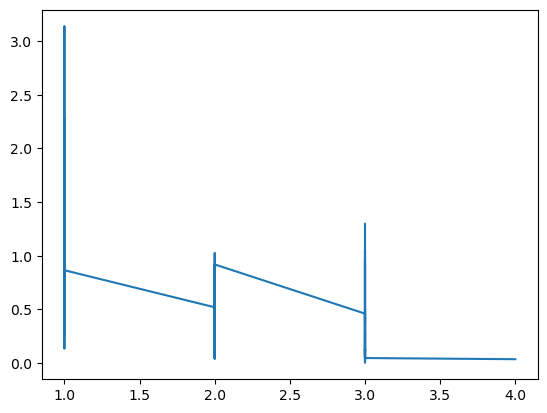

In [10]:
base_model = "models/gemini-1.5-flash-001-tuning"

operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    display_name="mml_to_python_4",
    source_model=base_model,
    epoch_count=4,
    batch_size=16,
    learning_rate=0.002,
    training_data=dataset,
)

for status in operation.wait_bar():
    time.sleep(10)

result = operation.result()
print(result)

snapshots = pd.DataFrame(result.tuning_task.snapshots)
plt.plot(snapshots['epoch'], snapshots['mean_loss'])

In [7]:
tuned_model = 'tunedModels/mmltopython1-si6b5lpywfhi'
model = genai.GenerativeModel(model_name=tuned_model)
generation_config = GenerationConfig(temperature=0.1)

# mml = "\n<mml:mrow>\n<mml:mrow>\n<mml:mo>-</mml:mo>\n<mml:msqrt>\n<mml:mi>y</mml:mi>\n</mml:msqrt>\n</mml:mrow>\n<mml:mo>+</mml:mo>\n<mml:mrow>\n<mml:mi>cos</mml:mi>\n<mml:mfenced>\n<mml:msub>\n<mml:mi>Υ</mml:mi>\n<mml:mi>ξ</mml:mi>\n</mml:msub>\n</mml:mfenced>\n</mml:mrow>\n</mml:mrow>\n<mml:mo>=</mml:mo>\n<mml:mrow>\n<mml:mrow>\n<mml:msub>\n<mml:mi>Ψ</mml:mi>\n<mml:mi>G</mml:mi>\n</mml:msub>\n<mml:mrow>\n<mml:mi>log</mml:mi>\n<mml:mfenced>\n<mml:mi>M</mml:mi>\n</mml:mfenced>\n</mml:mrow>\n</mml:mrow>\n<mml:mo>-</mml:mo>\n<mml:mrow>\n<mml:mi>sin</mml:mi>\n<mml:mfenced>\n<mml:mrow>\n<mml:mn>2</mml:mn>\n<mml:mi>k</mml:mi>\n</mml:mrow>\n</mml:mfenced>\n</mml:mrow>\n</mml:mrow>\n"

prompt = f"""
<mml:mi>h</mml:mi>
  <mml:mo>=</mml:mo>
  <mml:mrow>
    <mml:msub>
      <mml:mi>h</mml:mi>
      <mml:mi>c</mml:mi>
    </mml:msub>
    <mml:mo>+</mml:mo>
    <mml:msub>
      <mml:mi>h</mml:mi>
      <mml:mi>g</mml:mi>
    </mml:msub>
  </mml:mrow>
"""

response = model.generate_content(prompt, generation_config=generation_config)

print(response.text)


h = Symbol('h')
h_c = Symbol('h_c')
h_g = Symbol('h_g')
e = Eq(h, h_c + h_g)


In [ ]:
def gemini_translate(filename, model_name):   
    predictions = []  
    i = 0
    with open(f"{filename}.csv", "r") as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            mml = repr(row[0])
            prompt = f"""
            You are an expert at translating MathML to Python code using the SymPy library. Translate the following MathML expression into a valid Python SymPy expression. 
            Ensure that all variables are treated as symbolic variables and each is defined separately on a new line. 
            Assume that SymPy has been imported as `from sympy import *` so DO NOT include any import statements in your output.
            Example: 
            MathML: '<mml:mi>h</mml:mi>\n<mml:mo>=</mml:mo>\n<mml:mrow>\n<mml:msub>\n<mml:mi>h</mml:mi>\n<mml:mi>c</mml:mi>\n</mml:msub>\n<mml:mo>+</mml:mo>\n<mml:msub>\n<mml:mi>h</mml:mi>\n<mml:mi>g</mml:mi>\n</mml:msub>\n</mml:mrow>'
            SymPy Python code: 'h = symbols('h')\nh_g = symbols('h_g')\nh_c = symbols('h_c')\ne = Eq(h, h_g + h_c)'
            
            Now, translate the following MathML expression into Python code using SymPy.
            MathML: {mml}
            SymPy Python code:
            """
            model = genai.GenerativeModel(model_name=model_name)
            generation_config = GenerationConfig(temperature=0.1)
            response = model.generate_content(prompt, generation_config=generation_config)
            text = response.text
            predictions.append(repr(text))
            i += 1
            print(f"Generated {i} predictions")
    with open(f"{filename}_predictions.txt", "w") as file:
        for pred in predictions:
            file.write(pred + "\n")

def evaluate_bleu(filename, model_name):
    gemini_translate(filename, model_name)

    with open(f"{filename}.csv", "r") as file:
        reader = csv.reader(file)
        next(reader)
        refs = [repr(row[1]) for row in reader]
    with open(f"{filename}_predictions.txt", "r") as file:
        preds = [row for row in file]

    bleu = sacrebleu.corpus_bleu(preds, [refs])
    print(f"SacreBLEU Score: {bleu.score}")

# evaluate_bleu("gemini_test_1", 'tunedModels/mmltopython1-si6b5lpywfhi')
evaluate_bleu("gemini_test_1", "models/gemini-1.5-flash")

Generated 1 predictions
Generated 2 predictions
Generated 3 predictions
Generated 4 predictions
Generated 5 predictions
Generated 6 predictions
Generated 7 predictions
Generated 8 predictions
Generated 9 predictions
Generated 10 predictions
Generated 11 predictions
Generated 12 predictions
Generated 13 predictions
Generated 14 predictions
Generated 15 predictions
Generated 16 predictions
Generated 17 predictions
Generated 18 predictions
Generated 19 predictions
Generated 20 predictions
Generated 21 predictions
Generated 22 predictions
Generated 23 predictions
Generated 24 predictions
Generated 25 predictions
Generated 26 predictions
Generated 27 predictions
Generated 28 predictions
Generated 29 predictions
Generated 30 predictions
Generated 31 predictions
Generated 32 predictions
Generated 33 predictions
Generated 34 predictions
Generated 35 predictions
Generated 36 predictions
Generated 37 predictions
Generated 38 predictions
Generated 39 predictions
Generated 40 predictions
Generated